Duc Truong
<br>2018/10/08

# Can Movie Critics and Metascore Really Predict Box Office Hits?
<br>

## Objective
In this project, I would like to analyze the relationships between movie critics picks, metascore (viewers' rating) and box office hits (movie revenue) (i.e. is there a difference in movie revenues based on critics' ratings? Between critics pick and metascore, which one predicts box office performance better? etc.) Besides that, I also wanted to see if there is any other field that impacts movie's box office.
<br>
## Data Collection
For the data using in the study, I collected movie reviews and critics data in the full 2 years of 2003 and 2004 (2003-01-01 to 2004-12-31) from NYT API and OMDb API. Data from TMDb was also collected in the later part of the study, since it had useful features that NYT and OMDb API did not have. <br>
<BR>
## Original Data
(A .csv copy of merged NYT and Omdb data is available) <br>
The first 3 rows of the NYT critics review dataframe was as shown below:

In [226]:
import json
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from IPython.display import display
import time

In [227]:
# collecting data from IMDb API

offset = 0
url = "http://api.nytimes.com/svc/movies/v2/reviews/search.json?critics-pick=N&opening-date=2003-01-01;2004-12-31&offset=" + str(offset) +"&order=opening-date&api-key=e61b5b57d7ed43c5b869b5ff6686c8e7"
df = pd.read_json(url, orient = 'records')
nytdata = json_normalize(df['results'])
offset += 20
while not(df.empty):
    url = "http://api.nytimes.com/svc/movies/v2/reviews/search.json?critics-pick=N&opening-date=2003-01-01;2004-12-31&offset=" + str(offset) +"&order=opening-date&api-key=e61b5b57d7ed43c5b869b5ff6686c8e7"
    df = pd.read_json(url, orient = 'records')
    if df.empty:
        break
    nytdata = pd.concat([nytdata, json_normalize(df['results'])], ignore_index=True)
    offset += 20
    time.sleep(0.05) # to avoid the HTTPError: HTTP Error 429:
display(nytdata.head(3))


,byline,critics_pick,date_updated,display_title,headline,link.suggested_link_text,link.type,link.url,mpaa_rating,multimedia,opening_date,publication_date,summary_short
0,Manohla Dargis,0,2017-11-02 04:18:04,Suspect Zero,A Serial Killer Who Stalks Other Serial Killer...,Read the New York Times Review of Suspect Zero,article,http://www.nytimes.com/2004/08/27/movies/film-...,R,None,2004-08-27,2004-08-27,"Finally, a serial killer movie so preposterous..."
1,Manohla Dargis,0,2017-11-02 04:18:04,Hero,Hidden Truths in the Court of a King Who Would...,Read the New York Times Review of Hero,article,http://www.nytimes.com/2004/08/27/movies/film-...,PG-13,None,2004-08-27,2004-08-27,"In Zhang Yimou's &quot;Hero,&quot; an ambitiou..."
2,Manohla Dargis,0,2017-11-02 04:18:04,Exorcist: The Beginning,What the Devil Is Going On Here?,Read the New York Times Review of Exorcist: Th...,article,http://www.nytimes.com/2004/08/21/movies/film-...,R,None,2004-08-20,2004-08-21,"Spinning heads, cascades of pea soup and your ..."


It appeared that there were some movies from the NYT API having non-English title (such as Salomé, etc.). Searching for those movies in OMDb API and other sources will return errors. Therefore, I decided to drop the movie entries whose title are not fully English.

In [228]:
# Cleaning the data

# Drop the entries in which title is not in English
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

titleList = nytdata['display_title']
engCheck = []
for i in range(titleList.size):
    engCheck.append(isEnglish(titleList[i]))
dropIndex = [a for a in range(len(engCheck)) if engCheck[i] == False]
nytdata_cleaned = nytdata.drop(dropIndex)

In [229]:
apikey_omdb = "7e1ab203"
title = 't=' + nytdata_cleaned.display_title.str.replace(' ', '+')
req = 'http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title[0] + "&plot=full"
naBoxOfficeIndex = [] # to keep track of the movie without valid Box Office value
omdbdata = pd.DataFrame(columns=pd.read_json(req).columns.values) # DataFrame storing movies with valid Box Office
for i in range(title.size):
    req = 'http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title[i] + "&plot=full"
    if (requests.get(req).json().get('Response') == "False"):
        naBoxOfficeIndex.append(i)
        continue    
    a = pd.read_json(req)
    if (not (a.empty)) and (a.shape[1] == 25):
        if (a.loc[0].BoxOffice=="N/A" or a.loc[0].BoxOffice[0]!="$" ):
            naBoxOfficeIndex.append(i)
        else:
            omdbdata = omdbdata.append(a.loc[0], ignore_index=True)
    else:
        naBoxOfficeIndex.append(i)


Going through each movie title in the cleaned NYT dataframe, I got the BoxOffice, metascore etc. details from the OMDb API into another dataframe as shown below. I then filtered out the movies with invalid BoxOffice values (N/A or weird currency values), and then synchronized the data between OMDb and NYT dataframes, so that they both have exactly the same movies in the same order. <br>
After finishing this step, I have a total of 258 movies, which would be used for the analyses afterwards.

In [230]:
# Omdb data with valid values extracted from nytdata_cleaned
pd.set_option("display.max_columns", 60)
display(omdbdata.head(3))

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Plot,Poster,Production,Rated,Ratings,Released,Response,Runtime,Title,Type,Website,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Aaron Eckhart, Ben Kingsley, Carrie-Anne Moss,...",N/A,"$8,570,393","UK, Germany, USA",12 Apr 2005,E. Elias Merhige,"Crime, Horror, Mystery",English,37.0,When Dallas FBI Agent Thomas Mackelway violate...,https://m.media-amazon.com/images/M/MV5BZTA1Zj...,Paramount Pictures,R,"{'Source': 'Internet Movie Database', 'Value':...",27 Aug 2004,True,99 min,Suspect Zero,movie,http://www.suspectzero.com,"Zak Penn (story), Zak Penn (screenplay), Billy...",2004.0,tt0324127,5.9,"17,649"
1,"Stellan Skarsgård, Izabella Scorupco, James D'...",6 nominations.,"$41,784,746",USA,25 Oct 2005,Renny Harlin,"Horror, Mystery, Thriller",English,30.0,Archeologist Lankester Merrin is asked to go t...,https://m.media-amazon.com/images/M/MV5BMjI0Nz...,Warner Bros. Pictures,R,"{'Source': 'Internet Movie Database', 'Value':...",20 Aug 2004,True,114 min,Exorcist: The Beginning,movie,http://exorcistthebeginning.warnerbros.com/,"William Peter Blatty (movie The Exorcist), Wil...",2004.0,tt0204313,5.1,"30,672"
2,"Matthew Price, Andrew Hampton, Jarred Rumbold,...",N/A,"$58,156,435","USA, New Zealand",11 Jan 2005,Steven Brill,"Adventure, Comedy, Mystery",English,29.0,"Three friends, whose lives have been drifting ...",https://m.media-amazon.com/images/M/MV5BMjA0MT...,Paramount Pictures,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",20 Aug 2004,True,95 min,Without a Paddle,movie,http://www.withoutapaddlemovie.com,"Fred Wolf (story), Harris Goldberg (story), To...",2004.0,tt0364751,5.9,"40,524"


In [231]:
nytdata_cleaned = nytdata_cleaned.drop(naBoxOfficeIndex)
nytdata_cleaned = nytdata_cleaned.reset_index(drop=True)

# Data Analysis

## 1) How well do New York Times (NYT) movie critics pick box office hits?
To answer the first question, I first visualized the distributions of the box office hits when critics pick is "yes" (CP) or "no" (Not CP). A t-test then was used to see if there is a significant difference between the means of the box office when critics pick is "yes" or "no".

In [232]:
def clean(x):
    x = x.replace("$", "").replace(",", "").replace(" ", "")
    return float(x)

omdb_cleaned = omdbdata.copy()
omdb_cleaned["BoxOffice"] = omdb_cleaned["BoxOffice"].apply(clean)
# a copy of merged_data is available.
# merged_data = pd.concat([nytdata_cleaned, omdb_cleaned], axis=1)
merged_data = pd.read_csv("https://raw.githubusercontent.com/hdtruong12/movies-project/master/cleaned_data.csv")

I performed a Box plot to generally show the distribution of the movies Box Office for both critics picks and non-picks. Noted that in the graph, the "Not CP" label represents critics pick = False and the opposite for "CP" label.

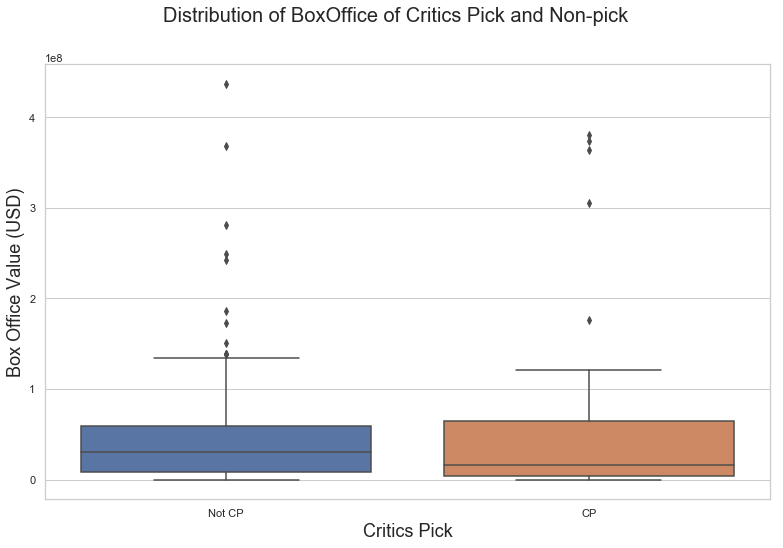

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13,8))
fig.suptitle('Distribution of BoxOffice of Critics Pick and Non-pick', fontsize=20)
sns.set(style="whitegrid")
fig1 = sns.boxplot(x = merged_data["critics_pick"], y = merged_data["BoxOffice"])
plt.xlabel('Critics Pick', fontsize=18)
plt.ylabel('Box Office Value (USD)', fontsize=18)
ax.set_xticklabels(['Not CP', 'CP'])
plt.show()

The distribution of the box office value was not similar to what I expected. There was not a clear difference between the picked movies and non picked movies. The highest and the median box office in the non picks were even higher than the ones from the picks (`$436,471,036` comparing to `$380,529,370`, and `$30,213,026` comparing to `$16,162,920`).
<BR>
I decided to perform a t-test to further confirm that if there is a significant difference in movie revenue between the box office value of the picks and non picks.
<br>
With the null hypothesis as the mean box office between picks and non picks are similar, the t-test return the result as shown below:

In [234]:
picks = merged_data.loc[merged_data['critics_pick'] == 1]
nonpicks = merged_data.loc[merged_data['critics_pick'] == 0]
picks = picks.reset_index(drop=True)
nonpicks = nonpicks.reset_index(drop=True)

In [235]:
from scipy.stats import ttest_ind
ttest_ind(picks["BoxOffice"],nonpicks["BoxOffice"])

Ttest_indResult(statistic=0.64850956988380959, pvalue=0.51723670647248032)

### Conclusion
Since the return pvalue was much higer than 0.05 (p = 0.517), we cannot reject the null hypothesis. Thus, there was not a significant difference between the box office means of critics picks and non picks.
<br>
By performing Box Plot and t-test, I realized that critic picks had no effect on Box Office. In fact, the highest and the median box office of the picks was even lower than ones of the nonpicks. This might be because that the critics did not evaluate and pick the movies based on their revenue potentials.

## 2) Is there a relationship between NYT movie review sentiment and crtics picks?
<br>
To answer this question, using BeautifulSoup library, I extracted the review text details from the review urls achieved from cleaned nytdata pool . The reviews are split up into 2 lists: critcis pick review, and non pick reviews. <br>
Then, by using TextBlob library, I calculated the sentiments polarity score for each reviews and store the scores into 2 different lists based on their critics pick category. Sentiment polarity is basically the emotions expressed in the review. The polarity has range from -1 to 1, in which the closer to 1 the polarity is, the more postive the review will be; and vice versa for -1. Then again, I performed a t-test between the polarities of picks and nonpicks. <br>
(There was 1 movie in the nonpicks whose URL returned the "page not found" error. For that movie, I just ignored it in the sentiment analysis.)
<br>
Txt files of pick and non pick reviews are available.

In [237]:
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request

def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    # print(soup.findAll("p", "story-body-text story-content"))
    # texts = soup.findAll(text=True)
    texts = soup.findAll("p", "story-body-text story-content")
    review = ""
    for t in texts:
        review += (t.text.strip() +"\n")
    return review

# this part is to achieve the reviews from the review urls, this would take about 10 minutes
# a shorter option is in the cell below where we can just load the reviews straight from the text file uploaded in my repo
p_reviews = []
for url in picks['link.url']:
    try: urllib.request.urlopen(url) # in case there is error openning the url
    except urllib.error.URLError as e:
        print(ind)
        print(e.reason)
        continue
    html = urllib.request.urlopen(url).read()
    a = text_from_html(html)
    p_reviews.append(a)
    
np_reviews = []
ind = 0
a = text_from_html(html)
for url in nonpicks['link.url']:
    try: urllib.request.urlopen(url) # in case there is error openning the url
    except urllib.error.URLError as e:
        continue
    html = urllib.request.urlopen(url).read()
    a = text_from_html(html)
    np_reviews.append(a)
    ind+=1

In [ ]:
# this cell is to load the reviews straight from github text files

'''import requests
page = requests.get("https://raw.githubusercontent.com/hdtruong12/movies-project/master/pick_reviews.txt")
p_reviews = page.text.split('~')
page = requests.get("https://raw.githubusercontent.com/hdtruong12/movies-project/master/nonpick_reviews.txt")
np_reviews  = page.text.split('~')'''

In [239]:
# you can skip this if you chose to load the files from github repo

# cleaning reviews string by dump out the director and actor/actress details
import re

temp = 0
for r in p_reviews:
    a = re.search(r'\b(is rated)\b', r)
    if a == None:
        temp+=1
        continue
    p_reviews[temp] = r[0:a.start()]
    temp+=1
    
temp = 0
for r in np_reviews:
    a = re.search(r'\b(is rated)\b', r)
    if a == None:
        temp+=1
        continue
    np_reviews[temp] = r[0:a.start()]
    temp+=1

In [240]:
from textblob import TextBlob
p_sen = []
np_sen = []
for r in p_reviews:
    testimonial =TextBlob(r)
    p_sen.append(testimonial.sentiment.polarity)
for r in np_reviews:
    testimonial =TextBlob(r)
    np_sen.append(testimonial.sentiment.polarity)



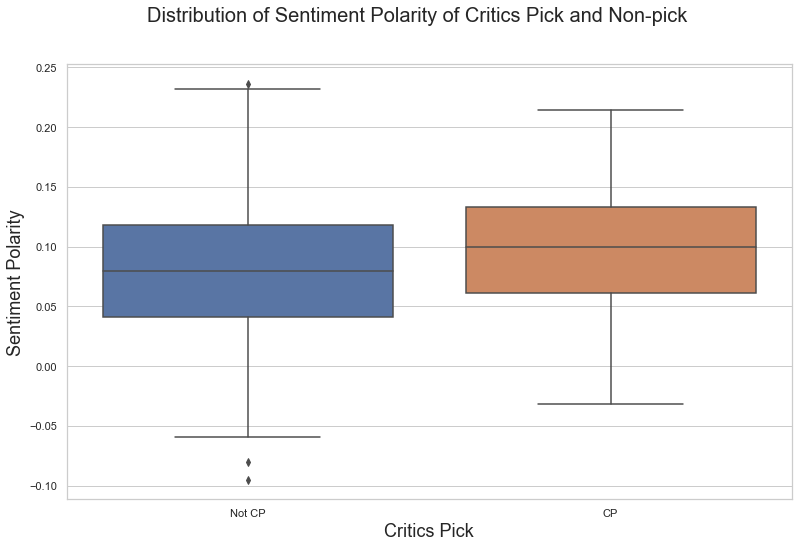

In [241]:
sendf = [np_sen, p_sen]
fig, ax = plt.subplots(figsize=(13,8))
fig.suptitle('Distribution of Sentiment Polarity of Critics Pick and Non-pick', fontsize=20)
sns.set(style="whitegrid")
plt.xlabel('Critics Pick', fontsize=18)
plt.ylabel('Sentiment Polarity', fontsize=18)
fig1 = sns.boxplot(data = sendf)
ax.set_xticklabels(['Not CP', 'CP'])
plt.show()

From the BoxPlot showing the distribution of sentiment polarity of Critics Picks and Nonpicks, I realized that there is a clear difference between the polarities of picks and nonpicks. For the nonpicks, the median polarity is lower than the median of the picks. Additionally, the polarities of the picks seemed to be more stable than the nonpicks (lower range, and mostly positive). I then performed a t-test between the polarities of picks and nonpicks to further confirm if there was a significant difference between them.

In [242]:
print("Mean polarity of critics picks: " + str(sum(p_sen)/len(p_sen)))
print("Mean polarity of non picks: "+ str(sum(np_sen)/len(np_sen)))
ttest_ind(p_sen,np_sen)

Mean polarity of critics picks: 0.0960959230444027
Mean polarity of non picks: 0.07774706435980788


Ttest_indResult(statistic=2.0272325592341023, pvalue=0.043678895383097514)

### Conclusion
The test returned the pvalue=0.0437 which was less than 0.05. Therefore, we can reject the null hypothesis and conclude that there was a significant difference between the means of the sentiments polarities of the picks and non picks. In speficic, the sentiment polarities of the critic pick movies tended to be higher than ones that were non picks. <br>
## 3) What characteristics of movies affect revenue?
To answer this question, in my opinion, instead of using a movie's revenue, we should use a movie's profit to determine its success. Movie's profit can be found by subtracting its budget from its total revenue. In this project, to make things simpler, I will assume that a movie is a success if its profit (i.e. revenue - budget) is greater than 0, and a movie is a flop if its profit is less than or equal to 0. (The threshold of success or flop can be modified as wanted. For the following analysis, the threshold were set to be 0.). <br>
Thus, instead of finding the characteristics of movies that affect revenue, I think it would make more sense if we determined the characteristics that have high impact on making movies profitable. With this in mind, the question became a binary classification problem. <br>
The features (characteristics) of movies that I would like to examine in this experiment are: <br>
Critics picks: {"Not CP": 0, "CP": 1} <br>
Metascore: float <br>
Sequel: {"not in a sequel": 0, "in sequel": 1} <br>
Award: {"didnt have any award/nominations": 0, "had award/nomination": 1} <br>
Budget: int (in USD) <br>
Production: String (Since one company might have different names, I did some data cleaning for this feature to make sure the result was more accurate) <br>
Popularity: float (value determined by TMDb based on the number of votes and views of a movie)

Since neither the OMDDb nor NYT API gave me all the features that I wanted to examine (i.e. no budget information from both), I fetched more features via the TMDb API. Also, I noticed that not all box office values from OMDb API matched with revenue values on TMDb. Therefore, for consistency, I decided to use the revenues and budgets from TMDb in the following analysis. <br>

### Data Preparation
First of all, I wanted to clean up the Production column in the merged_data dataframe. Using merged_data['Production'].value_counts(), we can have a overview of the distribution of the production companies. Since one company might appear in different names, I would group those "alias" into one unique name. And for the companies that had only 1 or 2 movies in the group, I would group them up into "Other".
<BR>
Original production companies distribution:

In [243]:
merged_data['Production'].value_counts()

Paramount Pictures                  24
Warner Bros. Pictures               21
Universal Pictures                  17
20th Century Fox                    16
New Line Cinema                     15
Buena Vista Pictures                13
Fox Searchlight Pictures            13
Sony Pictures                       10
Sony Pictures Classics               9
DreamWorks SKG                       8
MGM                                  7
Miramax Films                        7
Columbia Pictures                    7
Warner Bros.                         7
Focus Features                       6
Lions Gate Films                     5
Sony Pictures Entertainment          5
Walt Disney Pictures                 5
IFC Films                            4
MGM/UA                               3
Artisan Entertainment                3
Touchstone Pictures                  3
USA Films                            2
Dreamworks Distribution LLC          2
20th Century Fox Distribution        2
Net Effect Media         

Production values after cleaning:

In [244]:
merged_data['Production'] = merged_data['Production'].replace(['Warner Bros.', 'Warner Independent Pictures', 'Warner Independent', 'WB'], 'Warner Bros. Pictures')
merged_data['Production'] = merged_data['Production'].replace(['Paramount Classics'], 'Paramount Pictures')
merged_data['Production'] = merged_data['Production'].replace(['Universal Pictures Distributio'], 'Universal Pictures')
merged_data['Production'] = merged_data['Production'].replace(['20th Century Fox Distribution'], '20th Century Fox')
merged_data['Production'] = merged_data['Production'].replace(['Fox Searchlight'], 'Fox Searchlight Pictures')
merged_data['Production'] = merged_data['Production'].replace(['Buena Vista'], 'Buena Vista Pictures')
merged_data['Production'] = merged_data['Production'].replace(['Sony Pictures Classics', 'Sony Pictures Entertainment', 'Sony Pictures Releasing', 'Sony Screen Gems', 'Sony Picutres Classic', 'Screen Gems'], 'Sony Pictures')
merged_data['Production'] = merged_data['Production'].replace(['Dreamworks Distribution LLC'], 'DreamWorks SKG')
merged_data['Production'] = merged_data['Production'].replace(['MGM/UA', 'Metro-Goldwyn-Mayer (MGM)','Metro-Goldwyn-Mayer', 'MGM Distribution Company'], 'MGM')
merged_data['Production'] = merged_data['Production'].replace(['Walt Disney Pictures [us]'], 'Walt Disney Pictures')
merged_data['Production'] = merged_data['Production'].replace(['Lions Gate Films Inc.', 'Lions Gate Releasing', 'Lions Gate Distribution', "Lion's Gate Films"], 'Lions Gate Films')
merged_data['Production'] = merged_data['Production'].replace(['USA Films', 'Zeitgeist Films', 'Samuel Goldwyn Films', 'Fine Line Features', 'Newmarket Film Group', 'Net Effect Media', 'Film Foundry Releasing', 'New Yorker Films', 'Castle Rock Entertainment', 'Exhibition On Screen', 'Manhattan Pictures International', 'Fireworks Pictures',
                                                              'Palm Pictures', 'MTV Films', 'Samuel Goldwyn Company', 'Arenas Entertainment', 'United Artists'], 'Other')
merged_data['Production'].value_counts()

Warner Bros. Pictures       31
Sony Pictures               29
Paramount Pictures          26
Other                       23
Universal Pictures          18
20th Century Fox            18
New Line Cinema             15
Buena Vista Pictures        15
Fox Searchlight Pictures    14
MGM                         13
DreamWorks SKG              10
Lions Gate Films            10
Columbia Pictures            7
Miramax Films                7
Focus Features               6
Walt Disney Pictures         6
IFC Films                    4
Artisan Entertainment        3
Touchstone Pictures          3
Name: Production, dtype: int64

In [245]:
import tmdbsimple as tmdb
tmdb.API_KEY = 'cfa7214b7cb9a554bd0330fe6df80ccb'
movieid = merged_data['imdbID']
na_revenue_ind = []
na_budget_ind = []
mov_revenue = []
mov_budget = []
mov_sequel = []
mov_pop = []
for i in range(len(movieid)):
    response = tmdb.Movies(movieid[i]).info()
    if (response['revenue'] == 0):
        na_revenue_ind.append(i)
    if (response['budget'] == 0):
        na_budget_ind.append(i)
    mov_revenue.append(response['revenue'])
    mov_budget.append(response['budget'])
    mov_pop.append(response['popularity'])
    if (response['belongs_to_collection'] is None):
        mov_sequel.append(0)
    else:
        mov_sequel.append(1)
    time.sleep(0.20) # to avoid the HTTPError: HTTP Error 429:

In [246]:
mov_dropind = (list(set(na_budget_ind) | set(na_revenue_ind)))
temp_df = pd.DataFrame({
    'mov_revenue': mov_revenue,
    'mov_budget': mov_budget,
    'mov_sequel': mov_sequel,
    'mov_pop': mov_pop
})
temp_df['mov_success'] = np.where(temp_df['mov_revenue'].subtract(temp_df['mov_budget']) > 0, 1, 0)
features_df = pd.concat([merged_data, temp_df], axis=1)
features_df = features_df.drop(mov_dropind)
features_df = features_df.reset_index(drop=True)

The Award values were then cleaned by changing the value NaN (movie without any nomination or award) into 0, and otherwise into 1. <br>
There were also some movies with missing budget or revenue values. I dropped those movies out of our data pool in the features analysis. The result data pool had 178 movies, in which 136 of them were successes (76.4%), and 42 of the were flops (23.6%). The data pool was much smaller than I expected. But due to time limitation, I could not achieve more data from the APIs. <br>
The dataframe that would be used for model training and feature extraction had the format as shown below. The data were split up into a training set (80% of the data) and a testing set (the remaning 20%).

In [247]:
# Award values cleaning, 0 if there was no award or nominations, 1 if otherwise)
features_df['Awards'] = np.where(pd.isnull(features_df['Awards']), 0, 1)


In [248]:
reduced_df = pd.concat([features_df['critics_pick'], features_df['Metascore'], features_df['mov_sequel'], features_df['Awards'],
                          features_df['Production'], features_df['mov_budget'], features_df['mov_pop']], axis = 1)
reduced_df.head(3)


,critics_pick,Metascore,mov_sequel,Awards,Production,mov_budget,mov_pop
0,0,37,0,0,Paramount Pictures,27000000,5.075
1,0,30,1,1,Warner Bros. Pictures,80000000,5.795
2,0,29,1,0,Paramount Pictures,19000000,5.543


### Features Extraction
For the features extraction, I decided to use a Tree Classifier, extremely randomized trees (Extra Trees), to fit the data because of its nature of determining the most decisive features to split the trees. Moreover, I thought tree classifier would have high advantage in my situation, because there were 7 different features to consider, but maybe only a few of them were actually important. <br>
Since the Production feature is categorical, I applied one-hot-encoding the the dataframe to encode the feature into multiple binary features, so that it could work in the tree classifier.

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
reduced_df = pd.get_dummies(reduced_df, drop_first=0)
xtrain, xtest, ytrain, ytest = train_test_split(reduced_df, features_df['mov_success'], test_size = 0.2, random_state = 11)
model = ExtraTreesClassifier()
model.fit(xtrain, ytrain)

C:\Users\Duc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [250]:
print("Model Accuracy: ", model.score(xtest, ytest))
print("Features score array: ")
print(model.feature_importances_)

Model Accuracy:  0.805555555556
Features score array: 
[ 0.02966865  0.22146755  0.07704607  0.06183058  0.15301168  0.16913253
  0.02405928  0.00817591  0.00752681  0.00520083  0.00495432  0.00146488
  0.01591894  0.          0.03862768  0.01474221  0.01817263  0.01907037
  0.00904438  0.02468787  0.02763257  0.00045984  0.02035836  0.01168277
  0.03606329]


### Conclusion
After fitting the training data to the Extremely Randomized Trees classifier, I achieved a model with the accuracy of 80.6%. The accuracy in my opinion was acceptable, especially in this situation when I did not have a big data pool, and the classes distribution was skewed toward the success. <br>
The model also returned a list of importance score for each feature. Through the score list, the most 3 features that highly affected the success outcome of a movie were Metascore (0.221), movie's population score (0.169) and movie's budget (0.153). This totally made sense, because for a movie, if it has high rating (metascore) and interaction score (popularity) from viewers, it will be more likely to have high profit too. And if a movie has high budget, it would tend to have more magnificient scenes with famous actors/actresses starring in it, which would actract more viewers. <br>
The fourth highest score was movie's sequel (0.0770). Yet, because it was much lower than the 3rd highest score, I would not consider movie's sequel to be a determinant of the movie's success. The critic picks had very low importance score as well (0.0297), which matched with the result we got from the first question. The production company also was not an important factor in determining movie's success.

# Discussion
"Can Movie Critics and Metascore Really Predict Box Office Hits?" <br>
The answer is: the metascore is actually reliable in predicting Box Office. Tet, movie critics pick leans more toward to evaluating the movie's "content" value, not predicting the potential revenue value of the movies.
<BR>
In general, through the project I earned thoughtful experiences on data collection, sentiment analysis, and features engineering.
<BR>
In my opinion, the first question was pretty simple and straight forward. Yet, the result of the analysis did surprise me, since I thought that critics pick would be reliable when trying to predict movies that have high revenue potentials. <br> <br>
For the second question, it required me to spend time to read and understand the mechanics of sentiment analysis. After understanding the theory and how to make it work on Python, the process became straight forward. However, when I tried reading through several reviews that I got for the data, I realized that for most parts in the review, the writer just summarized the movie's content. This might significantly affect the accuracy of our automated sentiment polarity analysis, since movie summary might contain unintentional emotions and subjectivity in it. There was nothing I could do about that problem in the review, so I decided to go on and live with it. <br> <br>
The third question was actually my favorite. I had to read through several literature review papers about predicting movie success to get hints on where to start with this problem. From what I learned, in order to build a model that effectively predicts movie success, we would have to take a lot of different aspects into consideration, not just the features that I had above. The features could be split up into 3 basic categories: Who, What, and When. The "Who" features include the movie casting (actors/actresses), the production team (director, company), etc. that participate in the movie. The "What" features include the genres of the movie, also its rating (PG-13, R ...), and its content, etc. And then the "When" features include movie release time, the movie market condition at that time, etc. Moreover, we also need to consider the combinations of different features. For example, thinking about a situation that combines "What" and "When" features together: if a movie is about Christmas, for sure it will make more profit (and make more sense) if we release it around Christmas time, instead of releasing in the Summer. However, due to the complication of the problem, and due to time limitation of this project, I had to skip the mentioned features. <br> <br>
It is also important to mention that the movie profit cannot be determined by simply subtracting its budget from its total revenue like I did in the analysis. Because realistically speaking, not a 100% of the revenue would be handed in to the production party. The revenue usually would be split up between different parties, including sponsors, marketing team, theatrical parties, television, etc. based on the contracts they have with each other. I could of course increase the profit success threshold, to make the output class (Success/Flop) become more balanced, which might lead to a better model fitting ability. However, because I did not have that much details about the parties' revenue distribution, I simplified the profit calculation and threshold to make it fair between the movies.
<BR>
Another obstacle I met while working on this project was data collection. Neither of the APIs that I used had all the data features that I needed. Each API also required different method to collect and treat its data. Moreover, it appeared that different APIs had different values on the same feature, and there were a lot of missing values for all 3 APIs. Therefore, I had to drop a lot of data points to make the data consistent. I wished I had collected more data, but I did not expect to drop that much data, plus the APIs had limitation on the number of requests I could make in a certain time, which really decreased my speed in collecting data.
<BR>
Overall, I found the project was really practical and beneficial for me. I learned different techniques in analyzing data, from data collection, to cleaning, and then to analysis and interpretation. I did enjoy and had some fun while working on it, especially for the last question.
# References
Michael T. Lash, Kang Zhao: Early Predictions of Movie Success: the Who, What, and When of Profitability (2016) <br>
Neil Terry, John W. Cooley, Miles Zachary: The determinants of foreign box office revenue for English language movies <br>
<br>
And thanks Stack Overflow, Wikipedia, Kaggle, and especially Prof. Taback for making this project possible.


In [200]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')